# NCF Recommender with Explict Feedback

In this notebook we demostrate how to build a neural network recommendation system, Neural Collaborative Filtering(NCF) with explict feedback. We use Recommender API in Analytics Zoo to build a model, and use optimizer of BigDL to train the model. 

The system ([Recommendation systems: Principles, methods and evaluation](http://www.sciencedirect.com/science/article/pii/S1110866515000341)) normally prompts the user through the system interface to provide ratings for items in order to construct and improve the model. The accuracy of recommendation depends on the quantity of ratings provided by the user.  

NCF([He, 2015](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf)) leverages a multi-layer perceptrons to learn the user–item interaction function, at the mean time, NCF can express and generalize matrix factorization under its framework. includeMF(Boolean) is provided for users to build a NCF with or without matrix factorization. 

Data: 
* The dataset we used is movielens-1M ([link](https://grouplens.org/datasets/movielens/1m/)), which contains 1 million ratings from 6000 users on 4000 movies.  There are 5 levels of rating. We will try to classify each (user,movie) pair into 5 classes and evaluate the effect of algortithms using Mean Absolute Error.  
  
References: 
* A Keras implementation of Movie Recommendation([notebook](https://github.com/ririw/ririw.github.io/blob/master/assets/Recommending%20movies.ipynb)) from the [blog](http://blog.richardweiss.org/2016/09/25/movie-embeddings.html).
* Nerual Collaborative filtering ([He, 2015](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf))

## Intialization

* import necessary libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", message = "numpy.dtype size changed")
warnings.filterwarnings("ignore")

from zoo.models.recommendation import UserItemFeature
from zoo.models.recommendation import NeuralCF
from zoo.common.nncontext import init_nncontext
import matplotlib
from sklearn import metrics
from operator import itemgetter
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.dataset import movielens
from bigdl.util.common import *

matplotlib.use('agg')
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


* Initilaize NN context, it will get a SparkContext with optimized configuration for BigDL performance.

In [3]:
sc = init_nncontext("NCF Example")

## Data Preparation

* Download and read movielens 1M data

In [ ]:
rating_list = [i.strip().split("::") for i in open("/opt/work/ODSC-east-2019/datasets/NCF/ml-1m/ratings.dat","r").readlines()]    
movielens_data = np.array(rating_list).astype(int)

* Understand the data. Each record is in format of (userid, movieid, rating_score). UserIDs range between 1 and 6040. MovieIDs range between 1 and 3952. Ratings are made on a 5-star scale (whole-star ratings only). Counts of users and movies are recorded for later use.

In [8]:
min_user_id = np.min(movielens_data[:,0])
max_user_id = np.max(movielens_data[:,0])
min_movie_id = np.min(movielens_data[:,1])
max_movie_id = np.max(movielens_data[:,1])
rating_labels = np.unique(movielens_data[:,2])

print(movielens_data.shape)
print(min_user_id, max_user_id, min_movie_id, max_movie_id, rating_labels)

(1000209, 3)
(1, 6040, 1, 3952, array([1, 2, 3, 4, 5]))


* Transform original data into RDD of sample. 
We use optimizer of BigDL directly to train the model, it requires data to be provided in format of RDD([Sample](https://bigdl-project.github.io/master/#APIGuide/Data/#sample)). A `Sample` is a BigDL data structure which can be constructed using 2 numpy arrays, `feature` and `label` respectively. The API interface is `Sample.from_ndarray(feature, label)`

In [9]:
def build_sample(user_id, item_id, rating):
    sample = Sample.from_ndarray(np.array([user_id, item_id]), np.array([rating]))
    return UserItemFeature(user_id, item_id, sample)
pairFeatureRdds = sc.parallelize(movielens_data).map(lambda x: build_sample(x[0], x[1], x[2]))
pairFeatureRdds.take(3)

* Randomly split the data into train (80%) and validation (20%), or any percentage combination of your choice.

In [11]:
# Create training and validation Pair Features Rdds
trainPairFeatureRdds, valPairFeatureRdds =

# Format the pair features rdds into rdds of sample
train_rdd = 
val_rdd = 

In [12]:
# Print the row count of the training dataset and show the first 3 rows


800205


[Sample: features: [JTensor: storage: [  1. 661.], shape: [2], float], labels: [JTensor: storage: [3.], shape: [1], float],
 Sample: features: [JTensor: storage: [  1. 914.], shape: [2], float], labels: [JTensor: storage: [3.], shape: [1], float],
 Sample: features: [JTensor: storage: [1.000e+00 3.408e+03], shape: [2], float], labels: [JTensor: storage: [4.], shape: [1], float]]

## Build Model

* In Analytics Zoo, it is simple to build a NCF model by calling the NeuralCF API. You need specify the user count, item count, and class number according to your data, then add hidden layers as needed. You can also choose to include matrix factorization in the network. The model could be fed into an Optimizer of BigDL or NNClassifier of analytics-zoo. Please refer to the documentation for more details. In this example, we demostrate how to use optimizer of BigDL. 

In [14]:
# Initialize the NeuralCF model with user_count, item_count, class_num, and hidden_layers
ncf = 

creating: createZooNeuralCF


## Setup the Optimizer

* Here, we show how to use an optimizer of BigDL to train a model.
Optimizer tries to minimize the loss of the neural net with respect to its weights/biases, over the training set. To create an Optimizer in BigDL, you want to at least specify arguments: model(a neural network model), criterion(the loss function), traing_rdd(training dataset) and batch size. Please refer to ([ProgrammingGuide](https://bigdl-project.github.io/master/#ProgrammingGuide/optimization/))and ([Optimizer](https://bigdl-project.github.io/master/#APIGuide/Optimizers/Optimizer/)) for more details to create efficient optimizers.

In [15]:
# Batch size should be a multiple of the total number of cores used in the Spark environment. 
# This is number of executors * num cores per executor. In this case the docker container has
# 1 executor and 2 cores, so the batch size must be a multiple of 2. Suggested batch sizes also
# depend on data size and available memory. 
# In this case suggested batch sizes are 2400, 2600, or 2800.
batch_size = 

# More epochs will mean more memory usage, which is limited in this docker container. 
# Suggested number of epochs is 3 to 6
num_epochs = 

# Suggested learning rate is 0.001 to 0.05
learning_rate = 

# Create the optimizer for the NeuralCF model
optimizer = Optimizer(
    model=,
    training_rdd=,
    criterion=, 
    end_trigger=,
    batch_size=,
    optim_method=
)

# Create the validation component of the optimizer
optimizer.set_validation(
    batch_size=,
    val_rdd=,
    trigger=,
    val_method=
)

creating: createClassNLLCriterion
creating: createMaxEpoch
creating: createAdam
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createMAE
creating: createClassNLLCriterion
creating: createLoss


## Collect logs

* TrainSummary and ValidationSummary are logs which allow user to trace how indicators (e.g. learning rate, training loss, throughput, etc.) change with iterations/time in an optimization process.

A function of config_summaries is defined to collect monitoring data during training and validation phases.

In [16]:
import datetime as dt
def config_summaries(optimizer):
    """
    :param: optimizer: the optimizer created in start_train()
    """
    app_name = 'recommender-' + dt.datetime.now().strftime("%Y%m%d-%H%M%S")

    # train summary
    train_summary = TrainSummary(log_dir="./log", app_name=app_name)
    train_summary.set_summary_trigger("Loss", SeveralIteration(1))
    optimizer.set_train_summary(train_summary)

    # validation summary
    val_summary = ValidationSummary(log_dir="./log", app_name=app_name)
    optimizer.set_val_summary(val_summary)

    print("saving logs to ./log/" + app_name)
    return train_summary, val_summary

train_summary, val_summary = config_summaries(optimizer)

creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to ./log/recommender-20190422-142504


## Train the model

In [18]:
# Train (optimize) the model (using the optimizer)

## Prediction

* Zoo models make inferences based on the given data using model.predict(val_rdd) API. A result of RDD is returned. predict_class returns the predicted label. 

In [20]:
# Predict the values of the data in the val_rdd
results = 
results.take(5)

# Predict the class of the data in the val_rdd
results_class = 
results_class.take(5)

[5, 5, 4, 4, 4]

* In Analytics Zoo, Recommender has provied 3 unique APIs to predict user-item pairs and make recommendations for users or items given candidates.
* Predict for user item pairs

In [21]:
# Predict the user-item pairs
userItemPairPrediction = 
for result in userItemPairPrediction.take(5): print(result)

UserItemPrediction [user_id: 1, item_id: 1193, prediction: 5, probability: 0.681655957647]
UserItemPrediction [user_id: 1, item_id: 2804, prediction: 5, probability: 0.593105648671]
UserItemPrediction [user_id: 1, item_id: 594, prediction: 4, probability: 0.468825126801]
UserItemPrediction [user_id: 1, item_id: 2398, prediction: 4, probability: 0.421406564516]
UserItemPrediction [user_id: 1, item_id: 1097, prediction: 4, probability: 0.424251420099]


* Recommend 3 items for each user given candidates in the feature RDDs

In [22]:
# Recommend 3 items for every user and print a few results
userRecs = 


UserItemPrediction [user_id: 1792, item_id: 653, prediction: 4, probability: 0.554907694643]
UserItemPrediction [user_id: 1792, item_id: 2881, prediction: 4, probability: 0.498902096557]
UserItemPrediction [user_id: 1792, item_id: 377, prediction: 4, probability: 0.48817186846]
UserItemPrediction [user_id: 3840, item_id: 898, prediction: 5, probability: 0.634115927125]
UserItemPrediction [user_id: 3840, item_id: 1, prediction: 5, probability: 0.568523966551]


* Recommend 3 users for each item given candidates in the feature RDDs

In [23]:
# Recommend 3 users for every item and print a few results
itemRecs = 


UserItemPrediction [user_id: 3626, item_id: 2816, prediction: 3, probability: 0.594452525724]
UserItemPrediction [user_id: 1764, item_id: 2816, prediction: 3, probability: 0.547411192162]
UserItemPrediction [user_id: 148, item_id: 2816, prediction: 3, probability: 0.43376617281]
UserItemPrediction [user_id: 2163, item_id: 1792, prediction: 5, probability: 0.440798048448]
UserItemPrediction [user_id: 1764, item_id: 1792, prediction: 4, probability: 0.65613083692]


## Evaluation

* Plot the train and validation loss curves

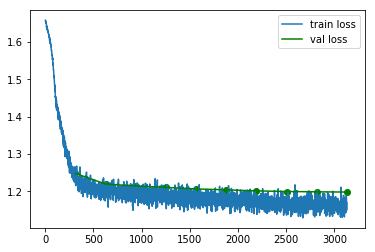

In [25]:
#retrieve train and validation summary object and read the loss data into ndarray's. 
loss = np.array(train_summary.read_scalar("Loss"))
val_loss  = np.array(val_summary.read_scalar("Loss"))

#plot the train and validation curves
# each event data is a tuple in form of (iteration_count, value, timestamp)


* plot the MAE curve during validation

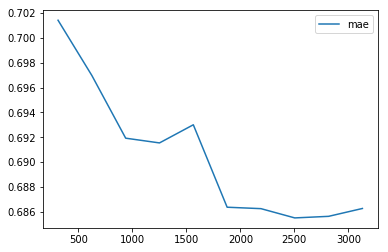

In [26]:
#retrieve train and validation summary object and read the loss data into ndarray's. 
val_mae  = np.array(val_summary.read_scalar("MAE"))

#plot the train and validation curves
# each event data is a tuple in form of (iteration_count, value, timestamp)


* output the final MAE on validation dataset

In [27]:
# Evaluate the NeuralCF Model using the Mean Absolute Error metric
res2 = 

creating: createMAE


In [28]:
'\n'.join([str(r) for r in res2])

'Evaluated result: 0.686666369438, total_num: 20172, method: MAE'